## Analysis of protein and ligand interaction profiles through graphs
### *Towards better interpretability of protein and ligand language models*

The strikingly low performance of powerful machine learning models in predicting protein-ligand interactions from ESM2 and ChemBERTa embeddings suggests that those language models, although encoding key features of proteins and ligands (e.g., ligand brain penetrability, toxicity, protein function) do not capture the information amino-acid and SMILES sequences contain about **interaction**.

Graphs offer a promising framework to study interactions between different entities. In the following, we will leverage this approach to gain understanding on the information that is encoded in the protein and ligand latent spaces ESM2 and ChemBERTa provide.

#### 1. Constructing a protein-ligand bipartite graph with IC50 as an inverse weight function

Interactions between proteins and ligands can be represented using a bipartite graph. 

Having chosen IC50 as our proxy for drug-target affinity, we defined the interaction weights of this graph as a monotonic, decreasing and positive function of IC50, additionally introducing a logarithm so as to account for the large variability in IC50 in the dataset, ranging from near-$0$ to $10^{13}$ concentration values.
\begin{equation}
w_{ij}=\frac{1}{\log(\text{IC50}_{ij}+1.05)}, i: \text{protein}, j: \text{ligand}.
\end{equation}.

In the previous section, we restricted our analysis to proteins presenting more than 10 interactions in the dataset, and selected only the best-binding ligands. Yet, the *non-optimal* interactions between ligands and proteins still provide important information on their respective interaction profiles. Two ligands binding very poorly to a common protein might share similarity in structure, properties, etc.. That we why we reintroduce the complete preprocessed dataset in the following, and thereafter extract the subgraph that retains only the protein-ligand interactions studied in the previous section.

In [1]:
import os
import pandas as pd
from src.scripts.graph_analysis import build_bipartite_graph, build_sub_bipartite_graph, plot_bipartite_graph, build_unipartite_graph, plot_unipartite_graph, load_graph_weights, load_chemberta, compute_cs_protein, compute_cs_ligand, plot_regression_model

In [2]:
# Data loading
data_path = 'data/processed_data/'
df_total = pd.read_csv(os.path.join(data_path, 'merged.csv')).drop_duplicates(['BindingDB Target Chain Sequence', 'Ligand SMILES'])
df_specific = pd.read_csv(os.path.join(data_path, 'filtered_best_ligand_ic50.csv')).rename(columns={'Ligand SMILES_x': 'Ligand SMILES'})

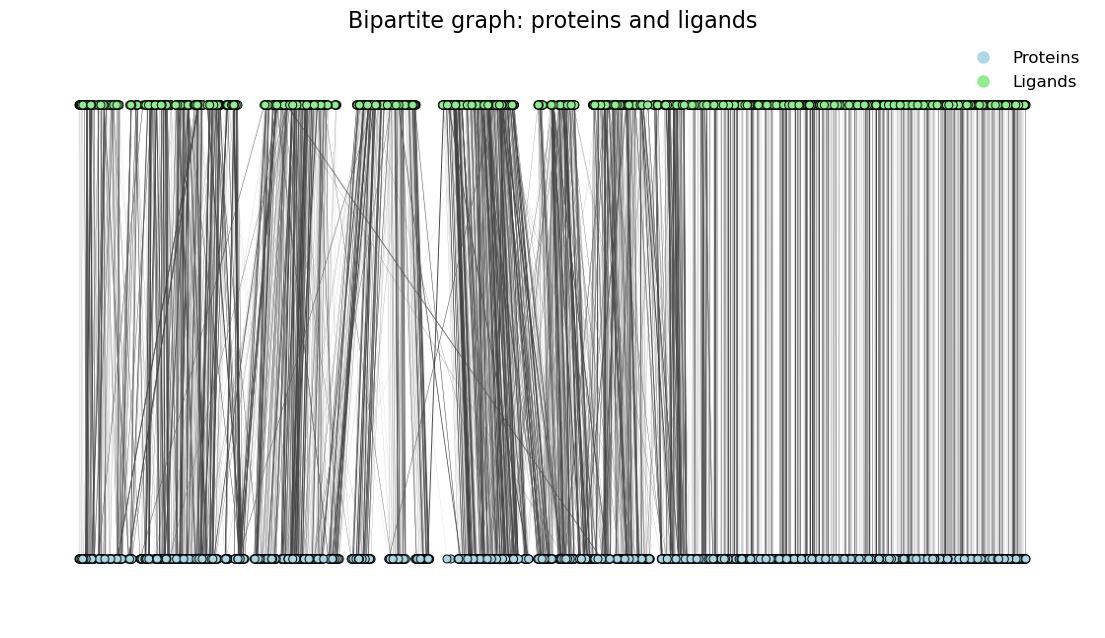

In [5]:
plot_path = 'plots/'
# Bipartite graph generation
bipartite_graph = build_bipartite_graph(df_total)

# Sub-bipartite graph extraction
sub_bipartite_graph = build_sub_bipartite_graph(bipartite_graph, df_specific)

# Plot sub-bipartite graph
plot_bipartite_graph(sub_bipartite_graph, save_path=plot_path)

#### 2. Extracting interaction profile similarities through bipartite graph projection
A bipartite graph can be projected onto a **unipartite graph** by connecting nodes that share a common neighbor, thereby representing only one type of entity instead of two. We adopted this strategy to compute the similarity of interaction profiles between proteins and between ligands respectively. Indeed, in a unipartite graph, the strength of the connection between two nodes reflects not only the number of common neighbors they share but also the strength of their interactions with those neighbors, i.e. how small is the IC50. Hence, if two proteins (resp. ligands) share a strong connection in the unipartite graph, it suggests that they have similar interaction profiles with ligands (resp. proteins). 

The connection weight therefore provides us with a **ground-truth of interaction profile similarity**.

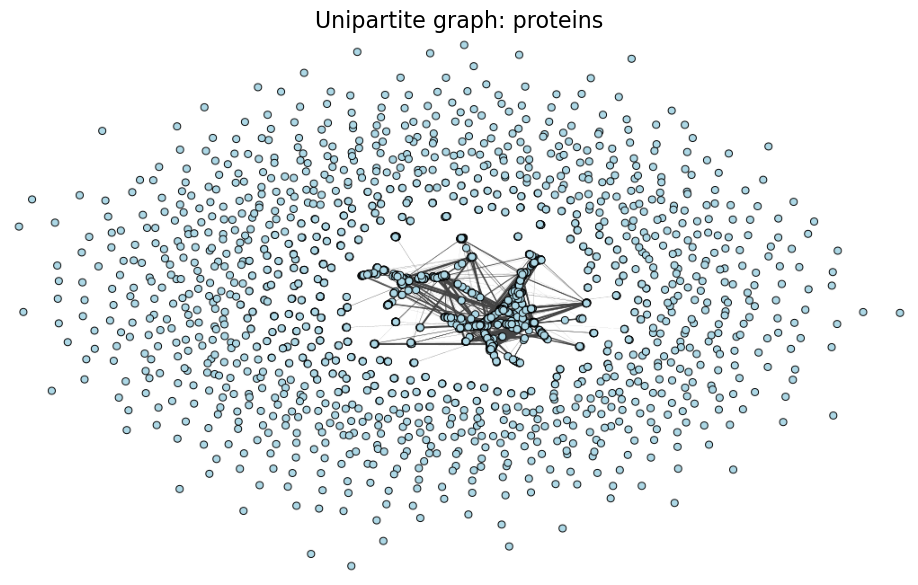

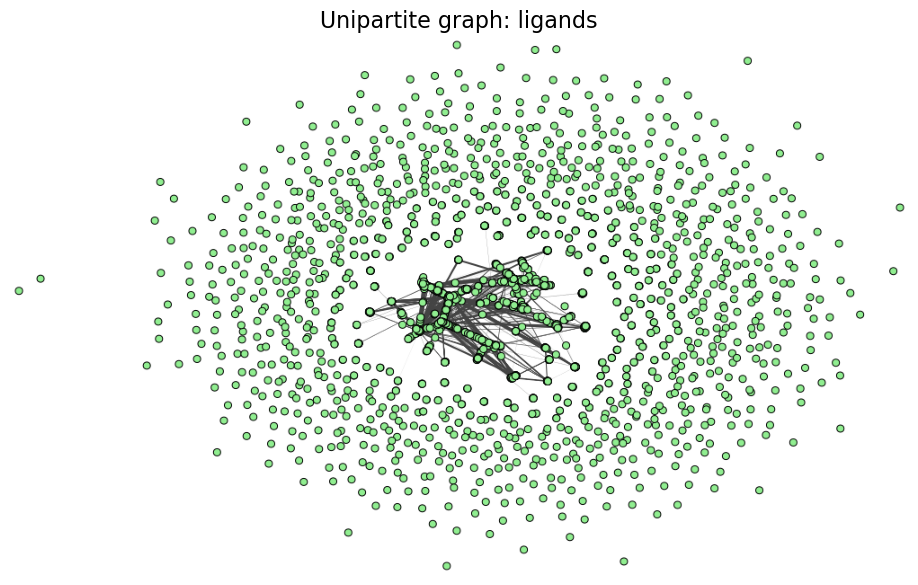

In [6]:
# Bipartite graph projection
unipartite_graph_proteins = build_unipartite_graph(sub_bipartite_graph, entity_type='protein')
unipartite_graph_ligands = build_unipartite_graph(sub_bipartite_graph, entity_type='ligand')

# Load connection weights in unipartite graphs
ligand_weights = load_graph_weights(sub_bipartite_graph, unipartite_graph_ligands, entity_type='ligand')
protein_weights = load_graph_weights(sub_bipartite_graph, unipartite_graph_proteins, entity_type='protein')

# Unipartite graphs plotting
plot_unipartite_graph(unipartite_graph_proteins, entity_type='protein', save_path=plot_path)
plot_unipartite_graph(unipartite_graph_ligands, entity_type='ligand', save_path=plot_path)

#### 3. Correlating interaction profile similarity in protein and ligand unipartite graphs with their respective ESM2 and ChemBERTa representations

We can use this ground-truth similarity in interaction profiles to evaluate whether ChemBERTa and ESM2 embeddings capture this characteristic of ligands and proteins. Instead of expecting a perfect matching between unipartite weights and network representation similarities, we aim to identify an association.

                                 OLS Regression Results                                
Dep. Variable:     ChemBERTa cosine similarity   R-squared:                       0.003
Model:                                     OLS   Adj. R-squared:                  0.003
Method:                          Least Squares   F-statistic:                     46.46
Date:                         Fri, 20 Dec 2024   Prob (F-statistic):           9.69e-12
Time:                                 10:08:49   Log-Likelihood:                 4242.0
No. Observations:                        15373   AIC:                            -8480.
Df Residuals:                            15371   BIC:                            -8465.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

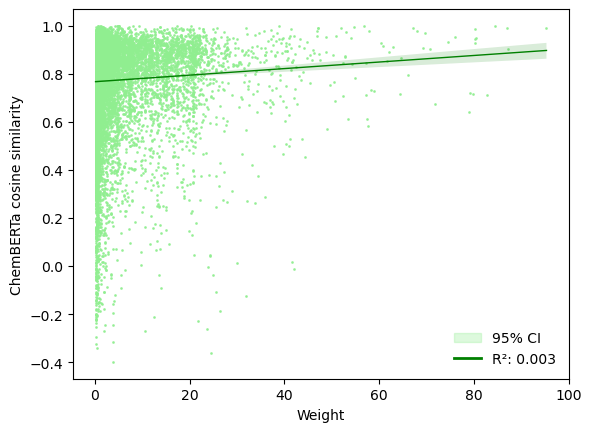

In [7]:
# Loading ChemBERTa embeddings
df_ligand_chemberta = load_chemberta(df_specific, os.path.join(data_path, 'unique_ligand_embeddings.csv'))

# Compute cosine similarity in ChemBERTa and ESM2 embeddings for the protein and ligands pairs of interest
protein_weights['ESM2 cosine similarity'] = compute_cs_protein(df_specific.copy(deep=True), protein_weights)
ligand_weights['ChemBERTa cosine similarity'] = compute_cs_ligand(df_ligand_chemberta, ligand_weights)

# Plot regression and display linear regression model summary for proteins and ligands
plot_regression_model(ligand_weights, 'ligand', save_path=plot_path)

                              OLS Regression Results                              
Dep. Variable:     ESM2 cosine similarity   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     2.020
Date:                    Fri, 20 Dec 2024   Prob (F-statistic):              0.155
Time:                            10:08:50   Log-Likelihood:                 16650.
No. Observations:                   15373   AIC:                        -3.330e+04
Df Residuals:                       15371   BIC:                        -3.328e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

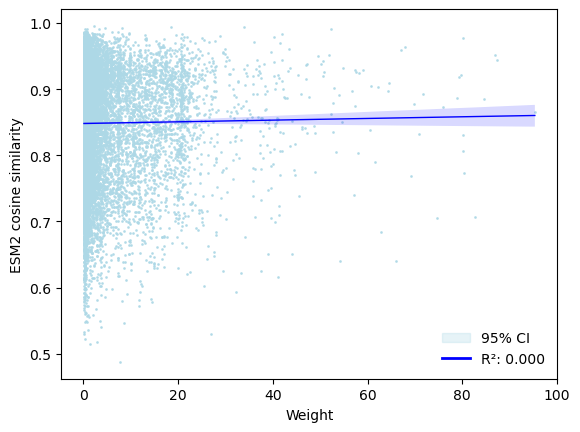

In [8]:
plot_regression_model(protein_weights, 'protein', save_path=plot_path)

While we should not place excessive emphasis on the exact values of the weights—given that they were manually defined using the IC50 to interaction strength mapping $1/\log(\cdot + 1.05)$—we would still expect to observe a consistent relationship between the interaction weight and the cosine similarity of the embeddings, provided the embeddings capture information about the interaction profiles. Yet, we clearly see that the cosine similarity of ChemBERTa and ESM2 embeddings is not a monotonic function of the weight, although it is increasing together with it.

Those results suggest that EMS2 and ChemBERTa protein and ligand representations do actually not capture the features needed to extract their interaction profiles, in turn potentially explaining the very poor performance of the predictive models we trained in the last section.

#### 4. Further perspectives into interaction-profile-aware clustering of ligands and proteins

Conducting **community analysis** on protein and ligand unipartite graphs is a promising technique for identifying clusters that reflect specific interaction profiles. These clusters, unlike those obtained by clustering the low-dimensional projection of ChemBERTa and ESM2 embeddings, could serve as a foundation for predicting potential ligand classes associated with a given protein.